## Overview
This notebook demos EDA on Medium Blog Posts with tag of 'Data Science'. The goal is to find some discriptive statistics for each field and find some relationship between blogpost's popularity and other features

### Dataset
I use scrapy to crawl blog posts on Medium and scrap blog's authour, title, heading, content, tags, and claps. There are 8626 Medium Blogposts with 'Data Science' Tag. I will perform EDA on this dataset for demo purpose

### Questions
1. Find the trend in number of 'data science' blogpost
2. Find the trend of blogpost for different topics
3. Get discriptive statistics for 'miniutes read', 'tags', 'author' and 'claps'
4. Try understand relationship between a blogpost's popularity and features
    1. get average claps for different authors
    2. get average claps for different tags
    3. get average claps for minutes read
    4. find relationship between claps and content word counts
    

In [2]:
import sys
import os
import json
import numpy as np
import pandas as pd

# my import
sys.path.append('../src/')
from text_preprocess import MediumBlogPost

import seaborn.apionly as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# path config
file_name = 'data-science.jl'
file_path = os.path.join(os.environ['DATA_PATH'], 'medium', file_name)

## load data

In [2]:
dfs = []
broadcast_dfs = []
with open(file_path) as f:
    for line in f:
        # get raw data
        row = MediumBlogPost(**json.loads(line)).to_frame()
        dfs.append(row)
        # get df_broadcast
        row_b = pd.DataFrame(MediumBlogPost(**json.loads(line)).to_dict())
        broadcast_dfs.append(row_b)


df = pd.concat(dfs).reset_index(drop=True)
df_broadcast = pd.concat(broadcast_dfs).reset_index(drop=True)

In [3]:
df.tail(2)

title publish_time  \
8625                   Reset – Carissa Yao – Medium   2018-08-24   
8626  XML and Scala – Technology@Nineleaps – Medium   2018-08-24   

                     author  \
8625            Carissa Yao   
8626  joydeep bhattacharjee   

                                                    url  \
8625     https://medium.com/@carijyao/reset-44c190974b4   
8626  https://medium.com/technology-nineleaps/xml-an...   

                             author_url  \
8625       https://medium.com/@carijyao   
8626  https://medium.com/@joydeepubuntu   

                                       headings  \
8625                                      Reset   
8626  XML and Scala Conquer XML land with Scala   

                                               contents  mins_read  claps  \
8625  I t’s my first day running for 3+ miles withou...          5      1   
8626  As data scientists and machine learning engine...          6      2   

     lang                                               tags  
8625   en  [Running, Challenge, Learning, Injury, Data Sc...  
8626   en      [Spark, Scala, Xml, Data Science, Technology]

## Basic EDA

### data points

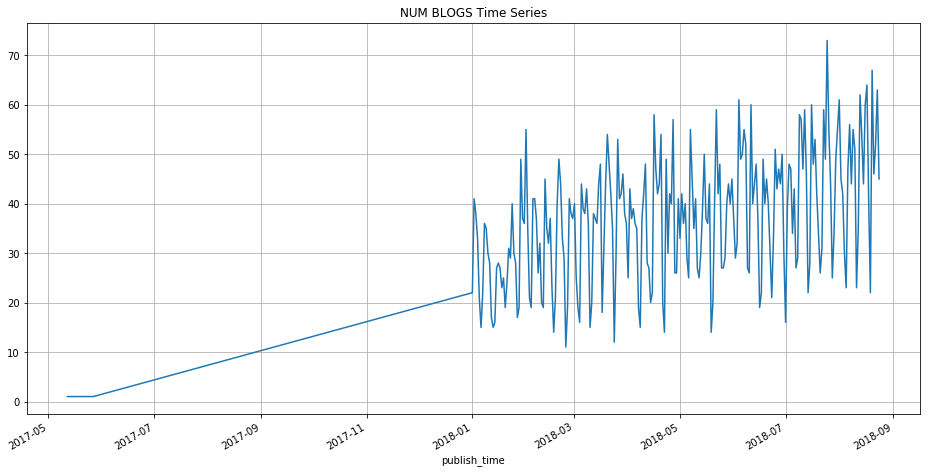

In [4]:
df.groupby('publish_time')['contents'].count().plot(
    figsize=(16, 8),
    title='NUM BLOGS Time Series',
    grid=True
)

### mins read

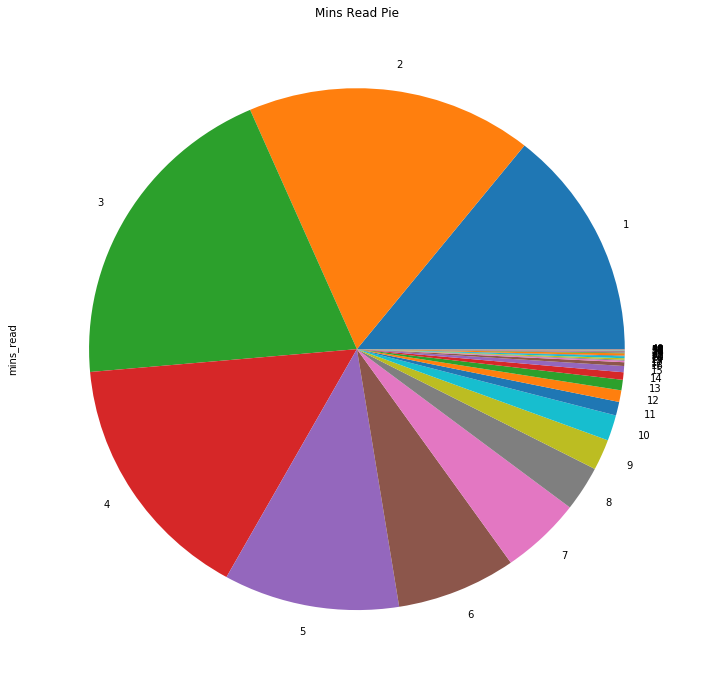

In [5]:
df.groupby('mins_read')['mins_read'] \
    .count() \
    .plot(
        kind='pie',
        figsize=(12, 12),
        fontsize=10,
        title='Mins Read Pie',
)

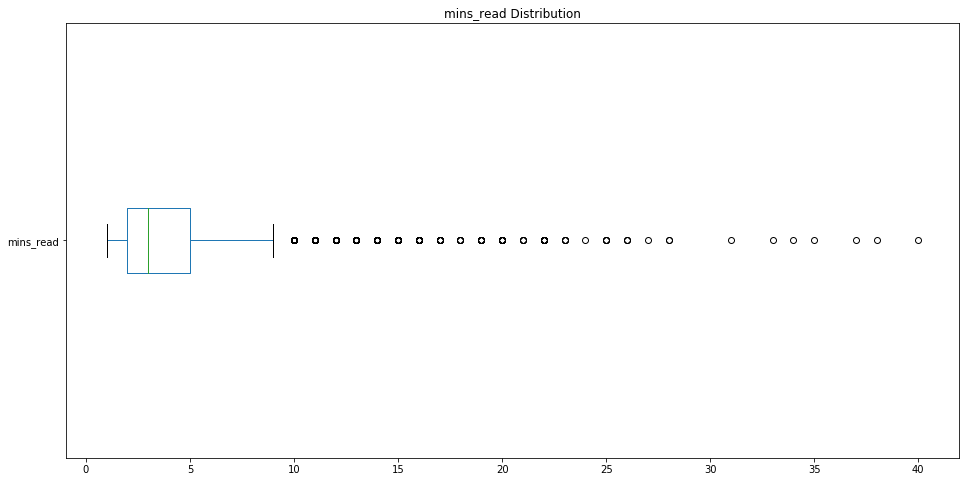

In [8]:
df['mins_read'].plot(
    kind='box',
    figsize=(16, 8),
    title='mins_read Distribution',
    vert=False
)

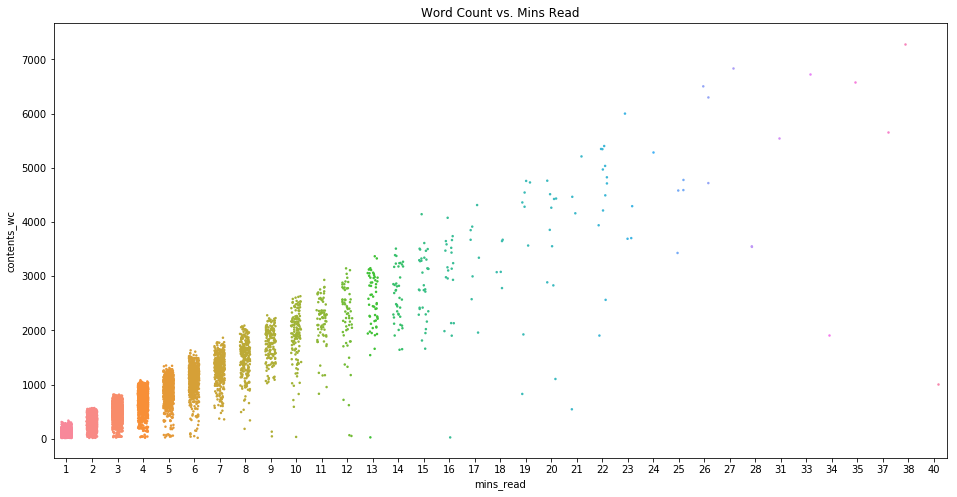

In [9]:
df['contents_wc'] = df.contents.apply(lambda x: len(x.split(' ')))
f, ax = plt.subplots(figsize=(16, 8))
ax.set_title('Word Count vs. Mins Read', fontsize=12)
sns.stripplot(x='mins_read', y='contents_wc', data=df, ax=ax, jitter=0.2, marker='.', size=5)

### tags

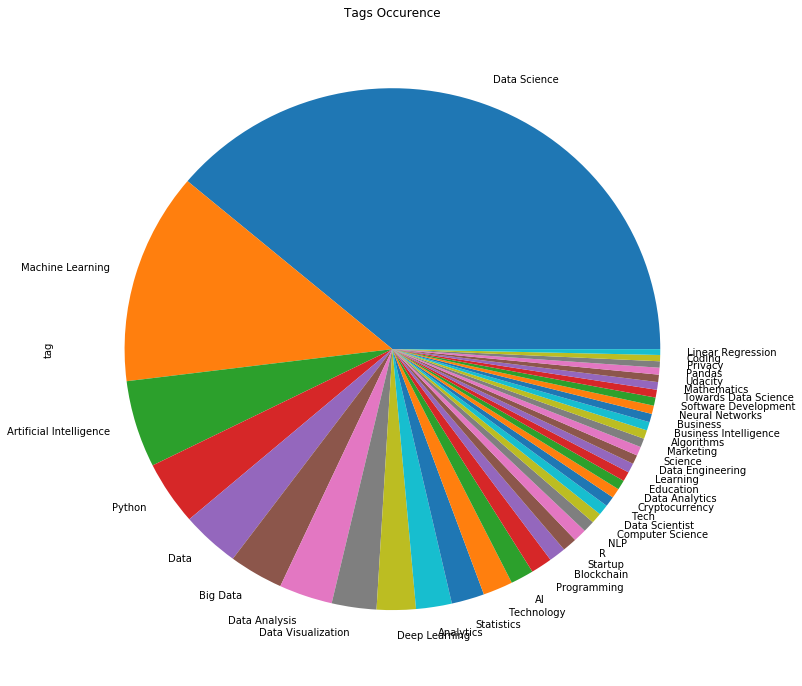

In [10]:
import itertools
tags = list(itertools.chain(*df.tags.values))
pd.DataFrame(tags, columns=['tag'])\
    .groupby('tag')['tag']\
    .count()\
    .sort_values(ascending=False)[:40]\
    .plot(
        kind='pie',
        figsize=(12, 12),
        fontsize=10,
        title='Tags Occurence',
)

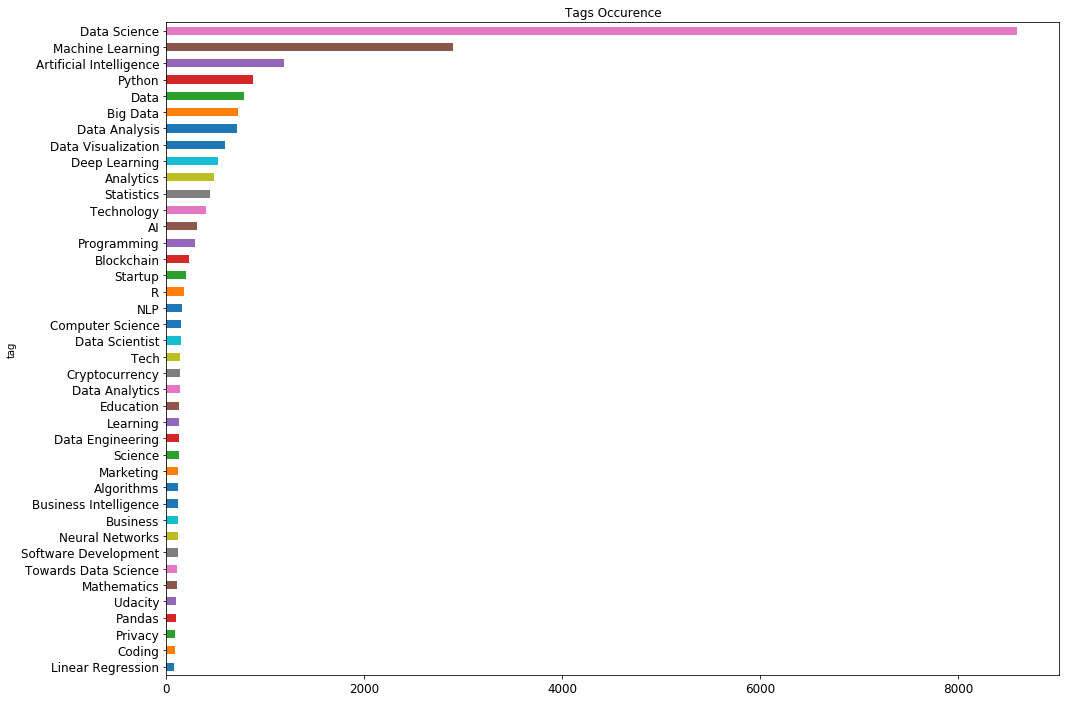

In [11]:
pd.DataFrame(tags, columns=['tag'])\
    .groupby('tag')['tag']\
    .count()\
    .sort_values(ascending=False)[:40][::-1]\
    .plot(
        kind='barh',
        figsize=(16, 12),
        fontsize=12,
        title='Tags Occurence',
)

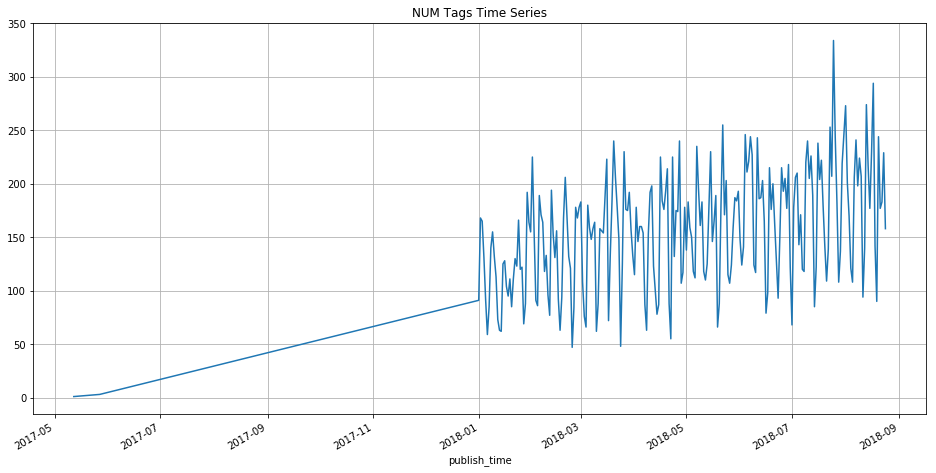

In [12]:
df_broadcast.groupby('publish_time')['tags']\
    .count()\
    .plot(
        figsize=(16, 8),
        title='NUM Tags Time Series',
        grid=True
)

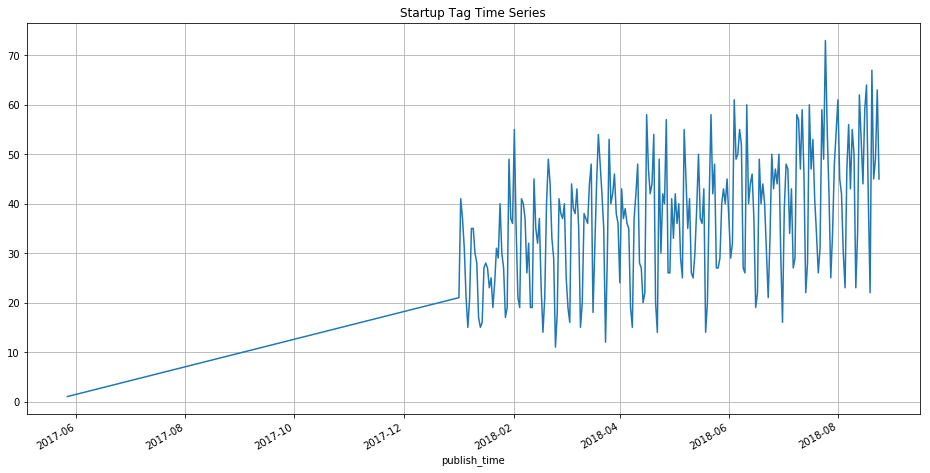

In [13]:
df_broadcast.query('tags=="Data Science"').groupby('publish_time')['tags']\
    .count()\
    .plot(
        figsize=(16, 8),
        title='Startup Tag Time Series',
        grid=True
)

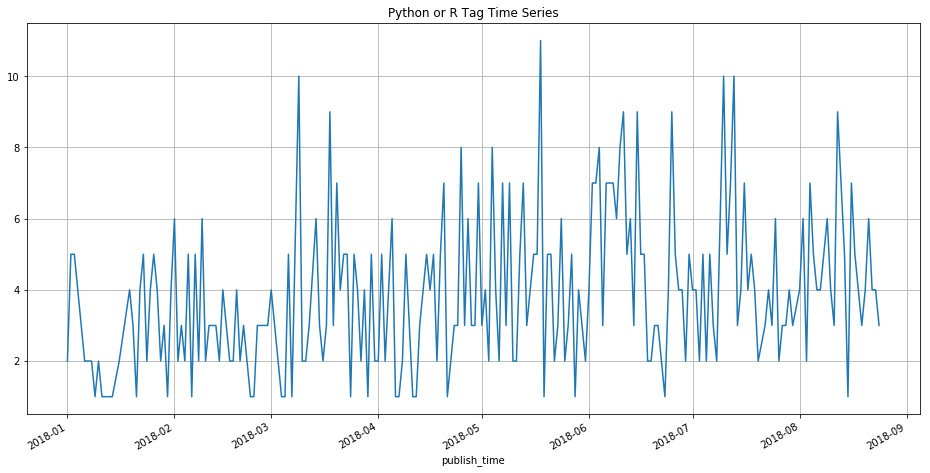

In [15]:
df_broadcast.query('tags=="Python"' or 'tags=="R"').groupby('publish_time')['tags']\
    .count()\
    .plot(
        figsize=(16, 8),
        title='Python or R Tag Time Series',
        grid=True
)

### author

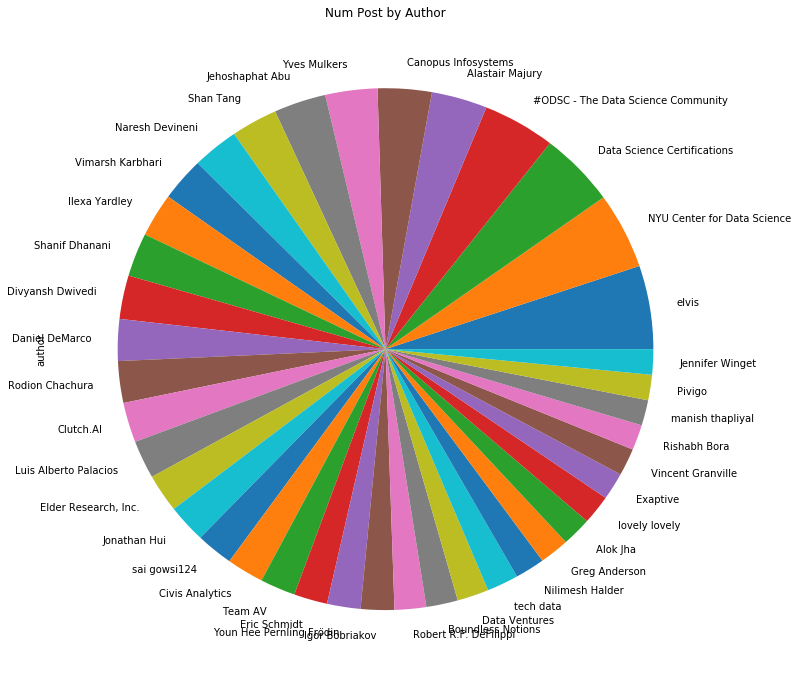

In [16]:
df.groupby('author')['author']\
    .count()\
    .sort_values(ascending=False)[:40]\
    .plot(
        kind='pie',
        figsize=(12, 12),
        fontsize=10,
        title='Num Post by Author',
)

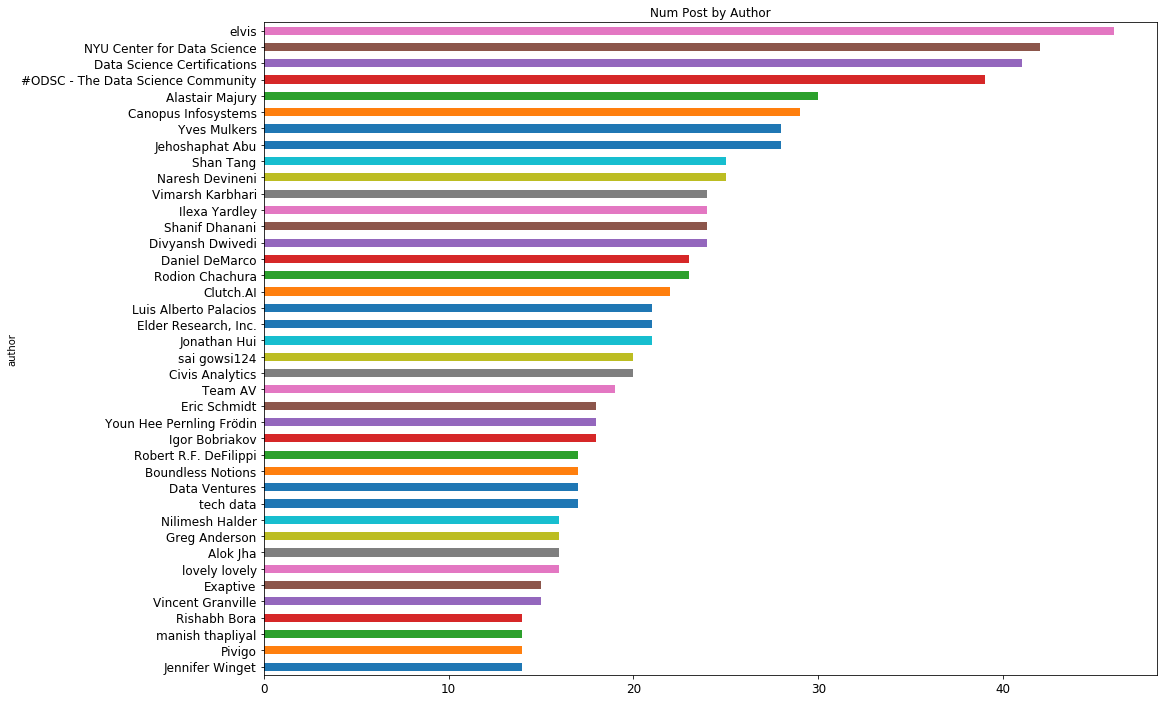

In [17]:
df.groupby('author')['author']\
    .count()\
    .sort_values(ascending=False)[:40][::-1]\
    .plot(
        kind='barh',
        figsize=(16, 12),
        fontsize=12,
        title='Num Post by Author',
)

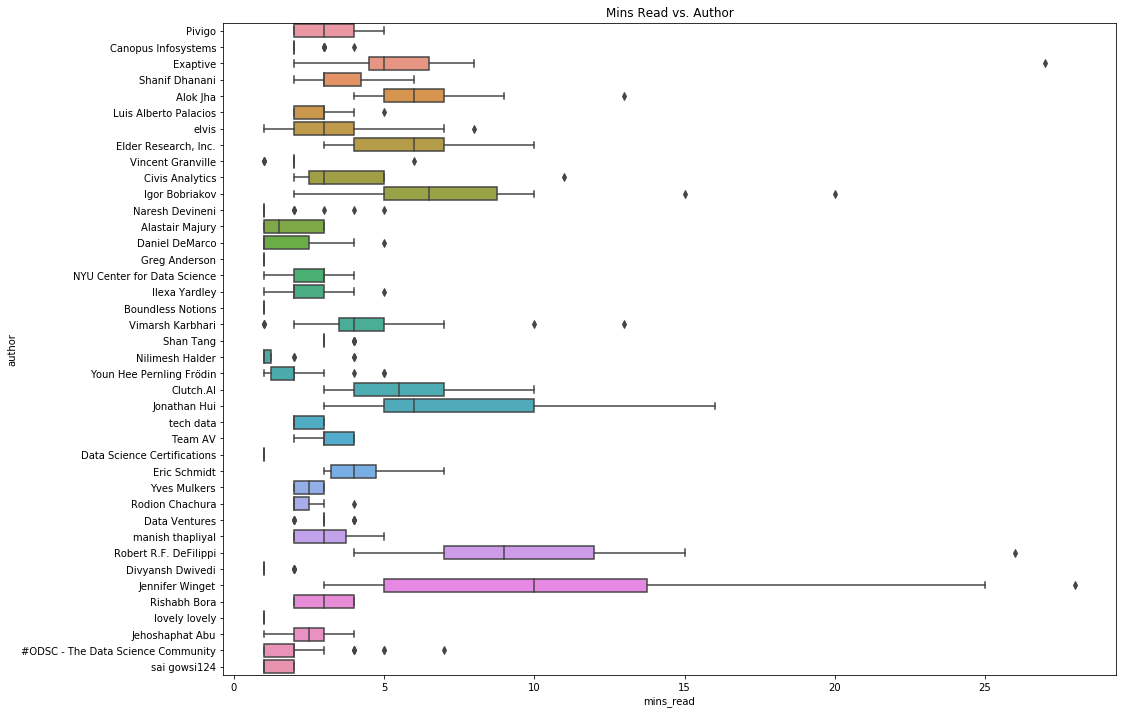

In [18]:
high_vol_author = df.groupby('author')['author']\
    .count()\
    .sort_values(ascending=False)[:40]\
    .index.values

high_vol_author_filter = df.author.isin(high_vol_author)

data = df[high_vol_author_filter.values]
data = data[data.claps < 1000]
f, ax = plt.subplots(figsize=(16, 12))
ax.set_title('Mins Read vs. Author', fontsize=12)
sns.boxplot(x='mins_read', y='author', data=data, ax=ax, hue_order='claps')

### claps analysis

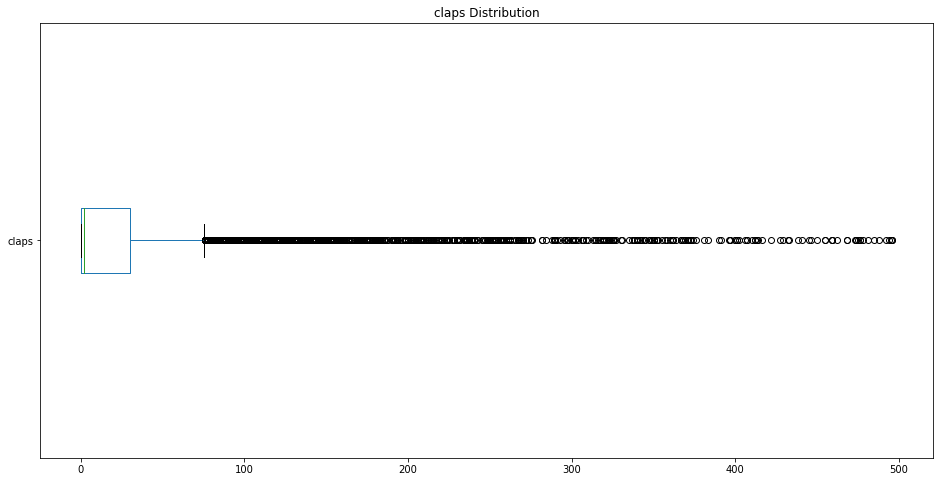

In [19]:
df[df.claps < 5e2]['claps'].plot(
    kind='box',
    figsize=(16, 8),
    title='claps Distribution',
    vert=False
)

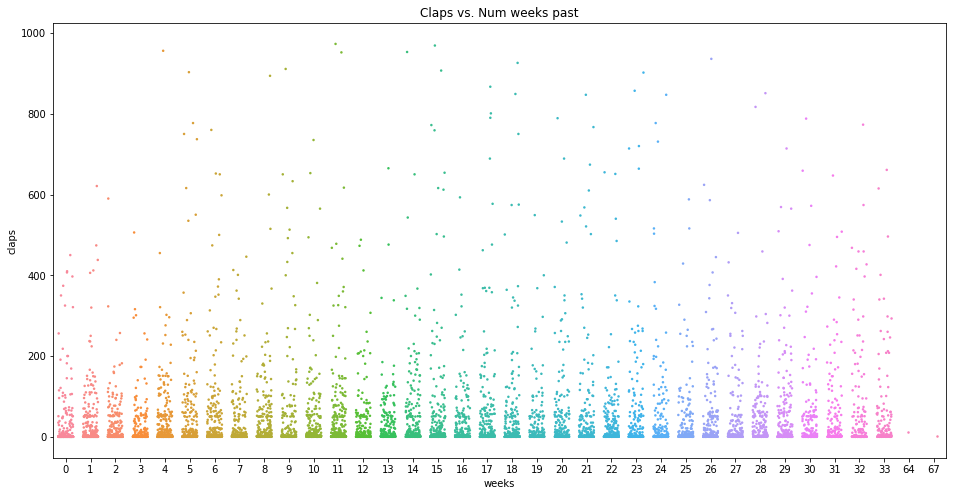

In [20]:
df['weeks'] = df.publish_time.apply(lambda x: int((df.publish_time.iloc[-1] - x) / np.timedelta64(1, 'W')))

data = df[df.claps < 1000]
f, ax = plt.subplots(figsize=(16, 8))
ax.set_title('Claps vs. Num weeks past', fontsize=12)
sns.stripplot(x='weeks', y='claps', data=data, ax=ax, jitter=0.3, marker='.', size=5)

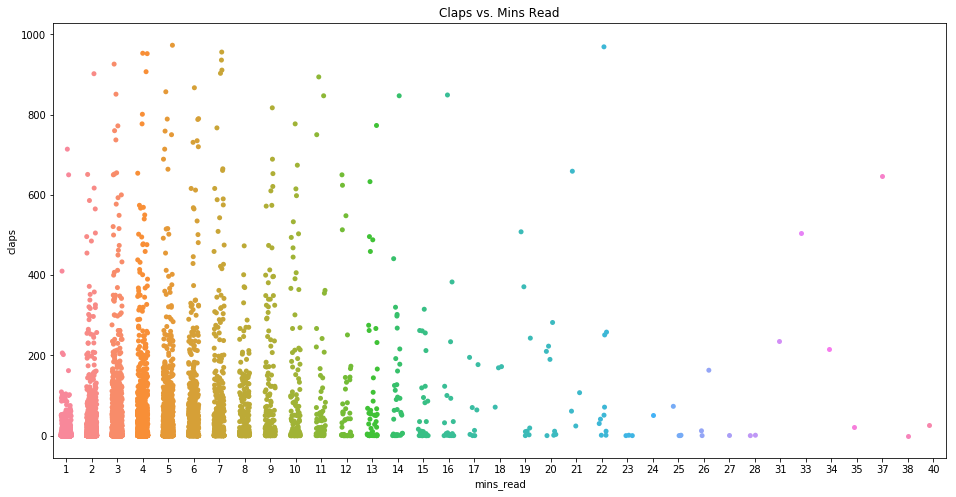

In [21]:
data = df[df.claps < 1000]
f, ax = plt.subplots(figsize=(16, 8))
ax.set_title('Claps vs. Mins Read', fontsize=12)
sns.stripplot(x='mins_read', y='claps', data=data, ax=ax, jitter=0.2)

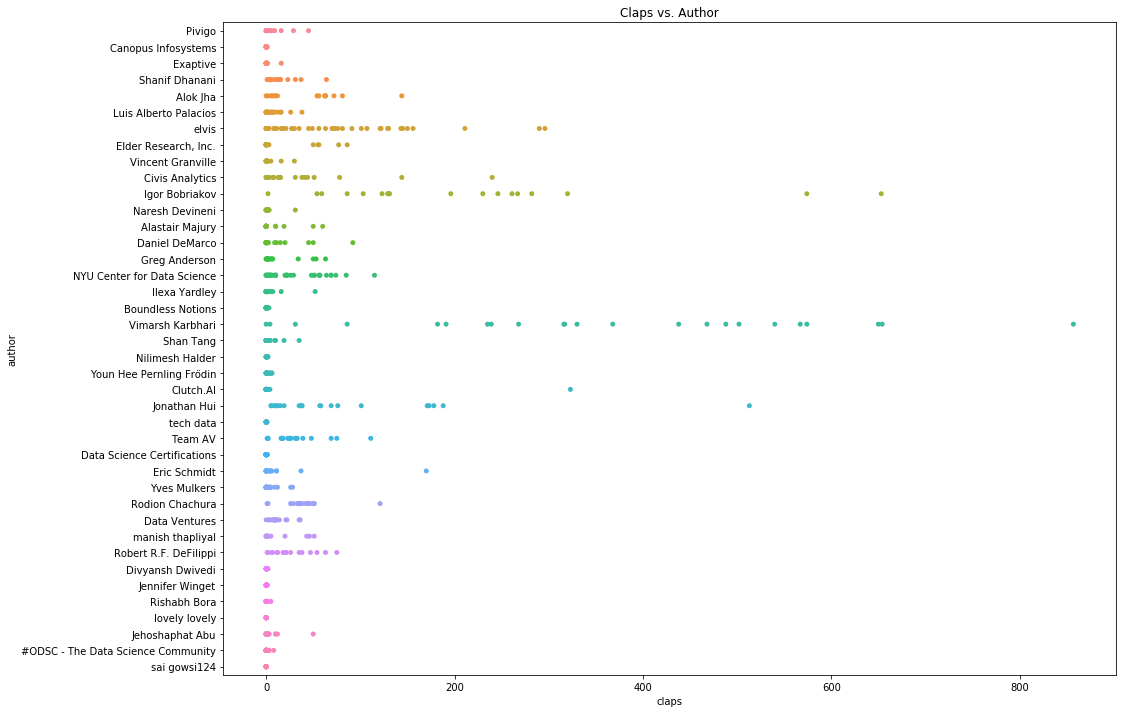

In [22]:
high_vol_author = df.groupby('author')['author'] \
    .count() \
    .sort_values(ascending=False)[:40] \
    .index.values

high_vol_author_filter = df.author.isin(high_vol_author)

data = df[high_vol_author_filter.values]
data = data[data.claps < 1000]
f, ax = plt.subplots(figsize=(16, 12))
ax.set_title('Claps vs. Author', fontsize=12)
sns.stripplot(x='claps', y='author', data=data, ax=ax)

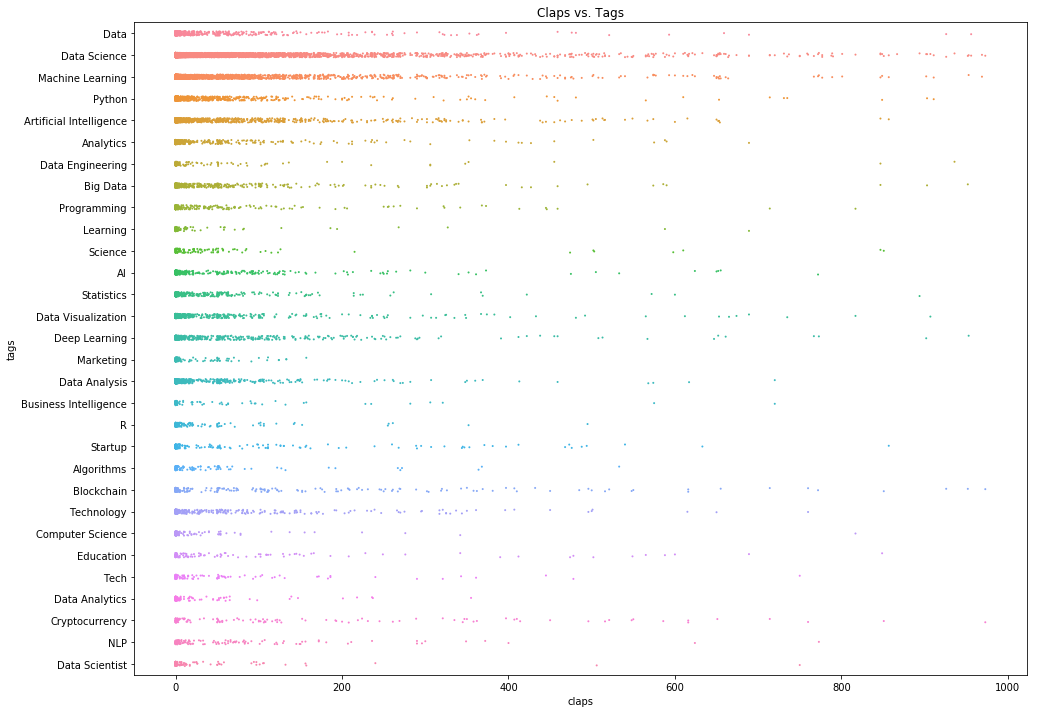

In [23]:
high_vol_tags = df_broadcast.groupby('tags')['tags']\
    .count()\
    .sort_values(ascending=False)[:30]\
    .index.values

high_vol_tags_filter = df_broadcast.tags.isin(high_vol_tags)

data = df_broadcast[high_vol_tags_filter.values]
data = data[data.claps < 1000]
f, ax = plt.subplots(figsize=(16, 12))
ax.set_title('Claps vs. Tags', fontsize=12)
sns.stripplot(x='claps', y='tags', data=data, ax=ax, jitter=1, marker='.', size=4)

### headings word count

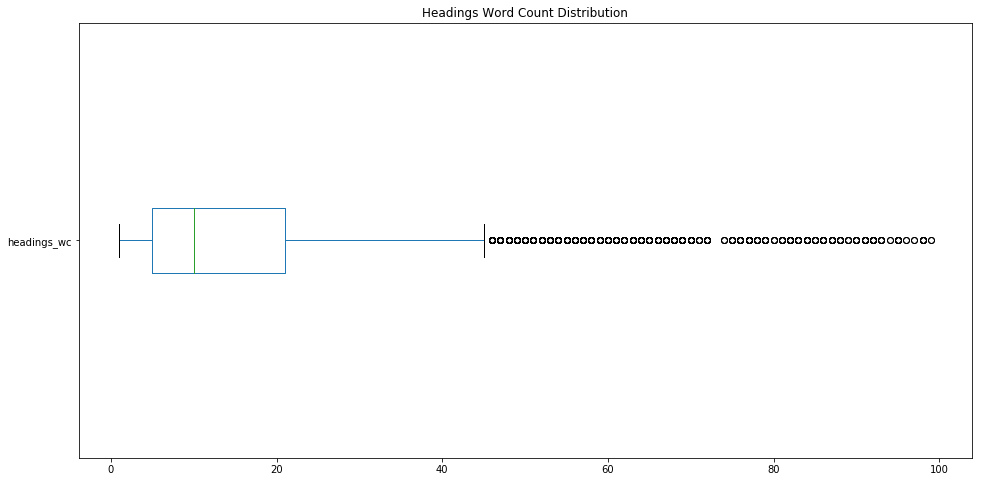

In [24]:
df['headings_wc'] = df.headings.apply(lambda x: len(x.split(' ')))
df[df.headings_wc < 100]['headings_wc'].plot(
    kind='box',
    figsize=(16, 8),
    title='Headings Word Count Distribution',
    vert=False
)

/Users/Kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


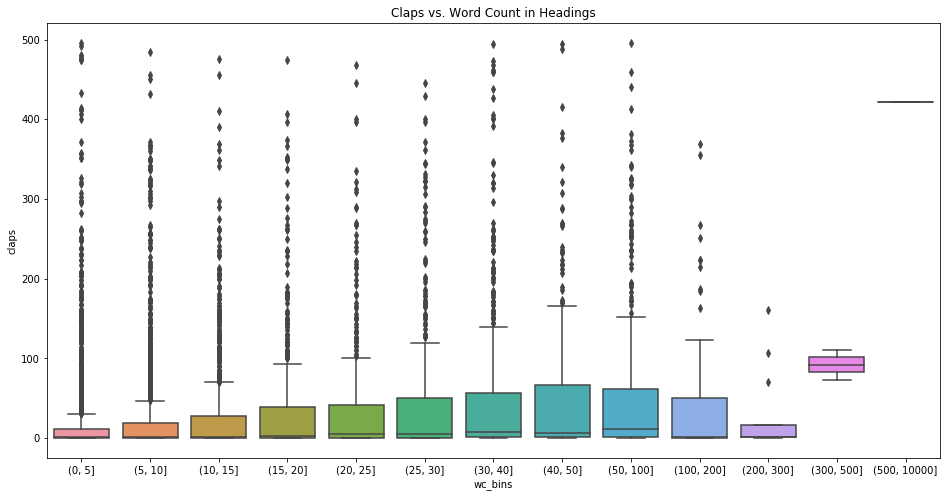

In [25]:
data = df[df.claps < 500]
data['wc_bins'] = pd.cut(data.headings_wc, bins=[0, 5, 10, 15, 20, 25, 30, 40, 50, 100, 200, 300, 500, 10000])
f, ax = plt.subplots(figsize=(16, 8))
ax.set_title('Claps vs. Word Count in Headings', fontsize=12)
sns.boxplot(x='wc_bins', y='claps', data=data, ax=ax)

### contents word count

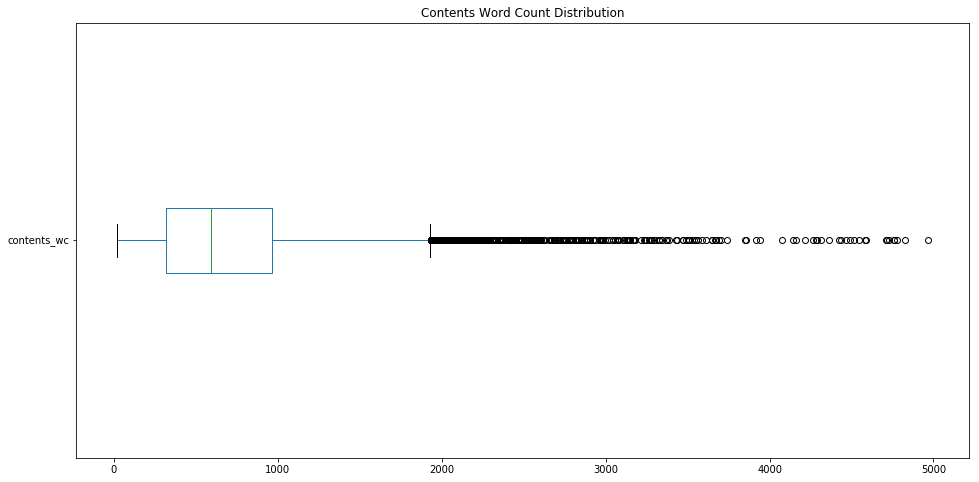

In [26]:
df['contents_wc'] = df.contents.apply(lambda x: len(x.split(' ')))
df[df.contents_wc < 5000]['contents_wc'].plot(
    kind='box',
    figsize=(16, 8),
    title='Contents Word Count Distribution',
    vert=False
)

/Users/Kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


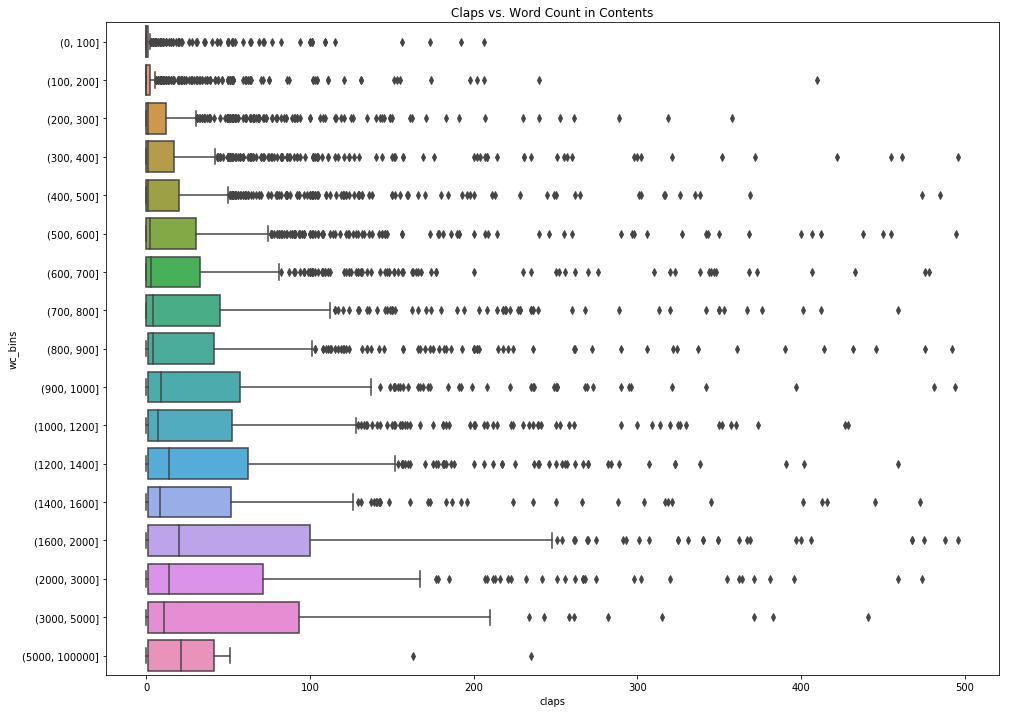

In [27]:
data = df[df.claps < 500]
data['wc_bins'] = pd.cut(
    data.contents_wc, 
    bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 2000, 3000, 5000, 100000])
f, ax = plt.subplots(figsize=(16, 12))
ax.set_title('Claps vs. Word Count in Contents', fontsize=12)
sns.boxplot(x='claps', y='wc_bins', data=data, ax=ax)